In [1]:
from landmark_detection.pipeline import Pipeline_Landmark_Detection
from benchmark.revisitop.dataset import configdataset
from benchmark.evaluation import run_evaluation2, save_evaluation_result, evaluate_search, build_place_of_img_from_cfg, build_q_place_gt, plot_heatmaps, plot_slices_vs_min_votes, plot_slices_vs_topk, plot_coverage_vs_precision, grid_min_sim_with_gt, build_score_mat, plot_cov_prec_vs_min_sim

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
VERSION = 208

# DATABASE
force_rebuild = False
save_every = 500
min_area = 0.40
min_sim_db = 0.90
keep_full_img = True

# PIPELINE
detector_file = "yolov8n-oiv7.pt"
extractor_onnx_file = "cvnet-sg-v" + str(VERSION) + ".onnx"
pipeline_onnx_file = "pipeline-yolo-cvnet-sg-v" + str(VERSION) + ".onnx"
image_dim = (640, 640)
allowed_classes = [41,68,70,74,87,95,113,144,150,158,164,165,193,205,212,224,257,
                    298,310,335,351,354,390,393,401,403,439,442,457,466,489,510,512,
                    514,524,530,531,543,546,554,565,573,580,588,591]
score_thresh = 0.05
iou_thresh = 0.40
scales = [0.7071, 1.0, 1.4142]
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
rgem_pr = 8
rgem_size = 5
gem_p = 3
sgem_ps = 10.0
sgem_infinity = False
eps = 1e-8
topk = 30
min_sim = 0.0
min_votes = 0.6
remove_inner_boxes = None
join_boxes = False

In [3]:
pipeline = Pipeline_Landmark_Detection(
        detector_file = detector_file,
        extractor_onnx_file = extractor_onnx_file,
        pipeline_onnx_file = pipeline_onnx_file,
        image_dim = image_dim,
        allowed_classes = allowed_classes,
        score_thresh = score_thresh,
        iou_thresh = iou_thresh,
        scales = scales,
        mean = mean,
        std = std,
        rgem_pr = rgem_pr,
        rgem_size = rgem_size,
        gem_p = gem_p,
        sgem_ps = sgem_ps,
        sgem_infinity = sgem_infinity,
        eps = eps,
        topk = topk,
        min_sim = min_sim,
        min_votes = min_votes,
        remove_inner_boxes = remove_inner_boxes,
        join_boxes = join_boxes
)

Creando versión ONNX del preprocess
Instanciando el preprocessor
Creando versión ONNX del detector
Ultralytics 8.3.146  Python-3.11.11 torch-2.7.0+cpu CPU (Intel Core(TM) i5-9300HF 2.40GHz)
YOLOv8n summary (fused): 72 layers, 3,492,527 parameters, 0 gradients, 10.5 GFLOPs

PyTorch: starting from 'C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 605, 8400) (6.9 MB)

ONNX: starting export with onnx 1.17.0 opset 16...
ONNX: slimming with onnxslim 0.1.54...
ONNX: export success  1.4s, saved as 'C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.onnx' (13.5 MB)

Export complete (1.8s)
Results saved to C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models
Predict:         yolo predict task=detect model=C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_dete

In [4]:
# Fixed Paths
CLASS_NAMES_PATH = os.path.join("oiv7.yaml")
DATASETS_PATH = os.path.abspath("datasets")
dataset = "roxford5k" # "rparis6k" # 
ROXFORD5K_PATH = os.path.join(DATASETS_PATH, dataset, "jpg")
ROXFORD5K_PKL = os.path.join(DATASETS_PATH, dataset, "gnd_roxford5k.pkl")
ROXFORD5K_CSV = os.path.join(DATASETS_PATH, dataset, "roxford5k_image_data.csv")
RESULTS_PATH = os.path.join("benchmark", "results", "results.csv")

ROXFORD5K_DF = os.path.join(DATASETS_PATH, dataset, "results", "df_" + dataset + "-v" + str(VERSION) + ".pkl") 
ROXFORD5K_DESC = os.path.join(DATASETS_PATH, dataset, "results", "desc_" + dataset + "-v" + str(VERSION) + ".pkl")

In [5]:
cfg = configdataset(dataset, DATASETS_PATH)
place_of_img, place_to_id, id_to_place = build_place_of_img_from_cfg(cfg)
q_place_gt = build_q_place_gt(cfg, place_to_id, place_of_img)

In [6]:
# Build/load roxford5k dataset
df_result, descriptors_final, places_db = pipeline.build_image_database(
    image_folder = ROXFORD5K_PATH,
    df_pickle_path = ROXFORD5K_DF,
    descriptor_pickle_path = ROXFORD5K_DESC,
    return_places_db = True,
    force_rebuild = force_rebuild,
    save_every = save_every,
    min_area = min_area,
    min_sim = min_sim_db,
    keep_full_img = keep_full_img
)

Procesando imágenes: 0it [00:00, ?it/s]


In [7]:
res, final_ranks, place_mat, sims_img = evaluate_search(
    df_result,
    places_db,
    place_of_img,
    q_place_gt,
    dataset = dataset,
    use_bbox = True,
    k_max = 15
)

>> roxford5k: Evaluating test dataset...
>> roxford5k: Loading features...
>> roxford5k: Retrieval...


In [8]:
acc, cov, precd, valid = res["accuracy"], res["coverage"], res["precision_decided"], res["valid"]

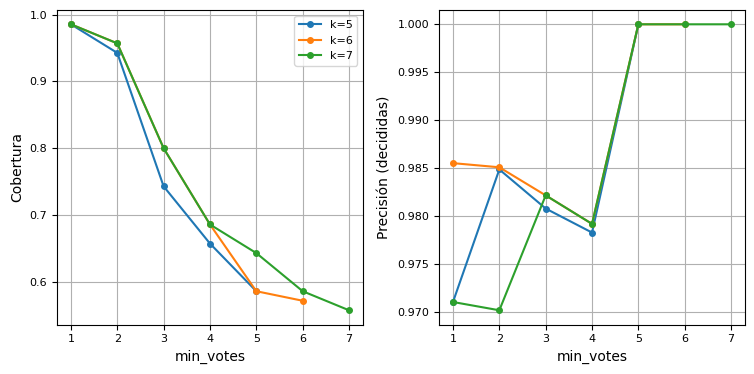

In [9]:
# 2) Cortes vs min_votes (elige k de interés)
plot_slices_vs_min_votes(acc, cov, precd, valid, k_list=(5, 6, 7))

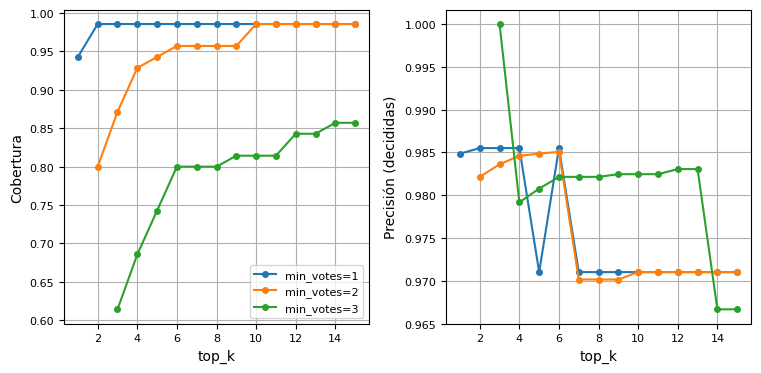

In [10]:
# 3) Cortes vs top_k (elige min_votes de interés)
plot_slices_vs_topk(acc, cov, precd, valid, v_list=(1, 2, 3))

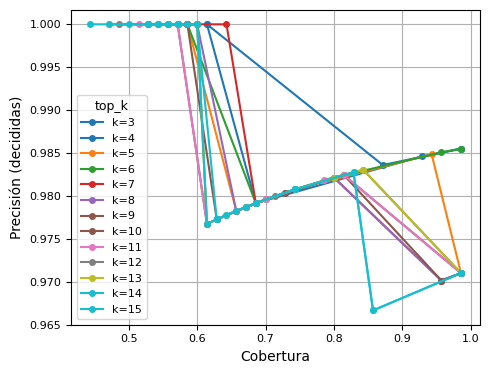

In [11]:
# 4) Cobertura vs Precisión (ver la frontera al variar min_votes para cada k)
plot_coverage_vs_precision(acc, cov, precd, valid, k_list=(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))

In [12]:
score_mat = build_score_mat(final_ranks, sims_img)

In [13]:
sim_grid = np.linspace(0.70, 0.97, 55)  # ajusta al rango real de tus similitudes

res = grid_min_sim_with_gt(
    place_mat,     # (Q, N) place_id por celda; -1 = sin lugar
    score_mat,     # (Q, N) similitud alineada con place_mat
    q_place_gt,    # (Q,) place_id correcto por query; -1 = sin GT
    topk = 6,
    min_votes = 1,
    sim_thresholds = sim_grid
)

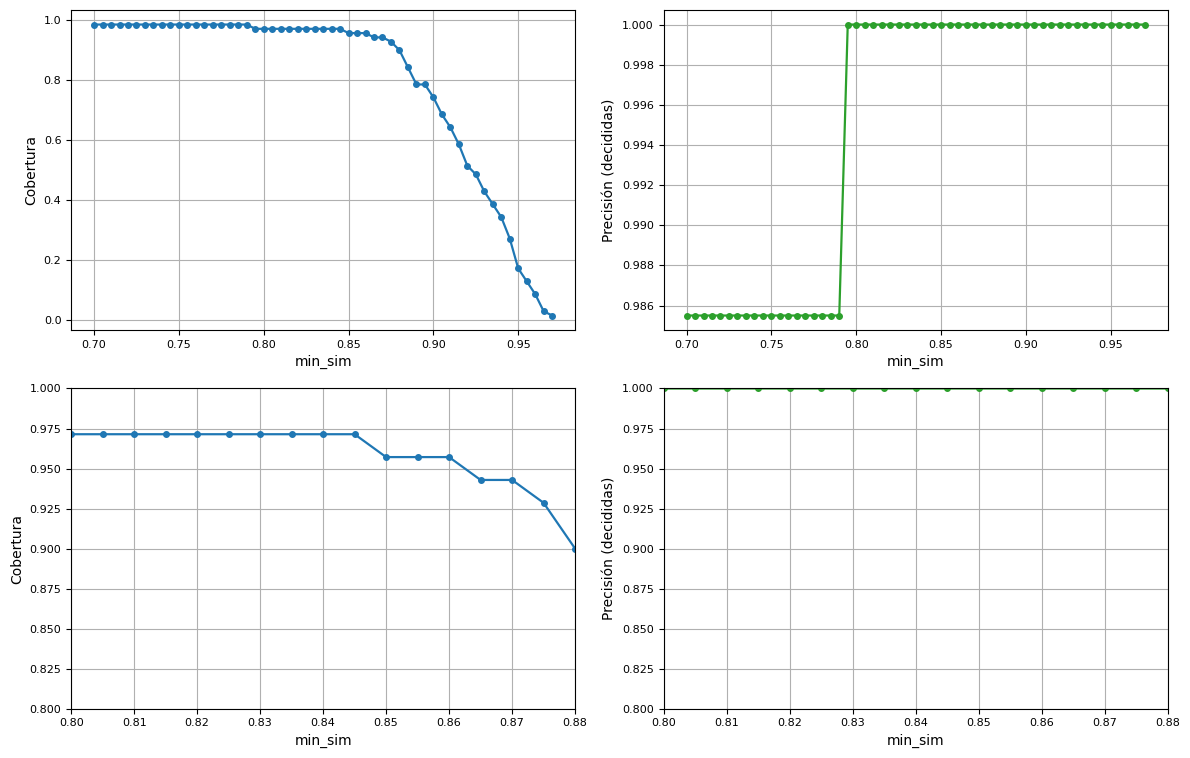

In [14]:
 plot_cov_prec_vs_min_sim(res, zoom_range=(0.8, 0.88), zoom_range_y=(0.8, 1.0))